In [1]:
include("../src/UNSflow.jl")
    

/Users/kiran/.julia/v0.5/Conda/deps/usr/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


UNSflow

In [2]:
using UNSflow

In [47]:
cref = 1.
bref = 4.
sref = 4.

patch1 = patch(0., -5., 0., 0., "FlatPlate", 1., 0., 0.11, 12)
patch2 = patch(0., 0., 0., 0., "FlatPlate", 1., 0., 0.11, 5)
patchdata = [patch1; patch2]

alphadef = ConstDef(15.*pi/180)
hdef = ConstDef(0.)
udef = ConstDef(1.)
kin = KinemDef3D(alphadef, hdef, udef)








UNSflow.KinemDef3D(UNSflow.ConstDef(0.2617993877991494),UNSflow.ConstDef(0.0),UNSflow.ConstDef(1.0),"Constant",0,[0.0])

In [48]:
surf = ThreeDSurf(cref, bref, sref, patchdata, kin, 1., 70, 35, 20)
field = ThreeDFlowField()
dtstar = 0.015
nsteps = 10 #round(Int,5./dtstar) + 1


10

In [49]:
   mat = Array(Float64, 0, 4)

    mat = mat'

    surf2d = TwoDSurf[]
    field2d = TwoDFlowField[]
    kinem2d = KinemDef[]

    dt = dtstar*surf.cref/surf.uref

    t = 0.

    AR = surf.bref/surf.cref

    bc = zeros(surf.nspan)
    a03d = zeros(surf.nspan)
    cl = zeros(surf.nspan)
    cd = zeros(surf.nspan)
    cm = zeros(surf.nspan)

lhs = zeros(surf.nspan, surf.nspan)
    rhs = zeros(surf.nspan)
bcoeff = zeros(surf.nspan)

    if surf.kindef.vartype == "Constant"

        for i = 1:surf.nspan
            # Kinematics at all strips is the same

            push!(kinem2d, KinemDef(surf.kindef.alpha, surf.kindef.h, surf.kindef.u))
            push!(surf2d, TwoDSurf(surf.patchdata[1].coord_file, surf.patchdata[1].pvt, kinem2d[i], [surf.patchdata[1].lc;]))
            #If 3D flow field is defined with disturbances or external vortices, these should be transferred to the 2D flowfield
            push!(field2d, TwoDFlowField())
        end
    end


In [50]:
     t = t + dt

        for i = 1:surf.nspan
            #Update kinematic parameters
            update_kinem(surf2d[i], t)

            #Update flow field parameters if any
            update_externalvel(field2d[i], t)

            #Update bound vortex positions
            update_boundpos(surf2d[i], dt)

            #Add a TEV with dummy strength
            place_tev(surf2d[i], field2d[i], dt)
        end

        kelv = KelvinConditionLLTldvm(surf, surf2d, field2d)

        #Solve for TEV strength to satisfy Kelvin condition

soln = nlsolve(not_in_place(kelv), [-0.1*ones(surf.nspan); zeros(surf.nspan)])

        for i = 1:surf.nspan
            field2d[i].tev[length(field2d[i].tev)].s = soln.zero[i]

            #Update incduced velocities on airfoil
            update_indbound(surf2d[i], field2d[i])

            #Calculate downwash
            update_downwash(surf2d[i], [field2d[i].u[1],field2d[i].w[1]])

            #Calculate first two fourier coefficients
            update_a0anda1(surf2d[i])

            bc[i] = surf2d[i].a0[1] + 0.5*surf2d[i].aterm[1]
        end

       

In [51]:
for i = 1:surf.nspan
            a03d[i] = 0
            for n = 1:surf.nspan
                nn = 2*n - 1
        a03d[i] = a03d[i] - real(nn)*soln.zero[surf.nspan+n]*sin(nn*surf.psi[i])/sin(surf.psi[i])
            end
        end

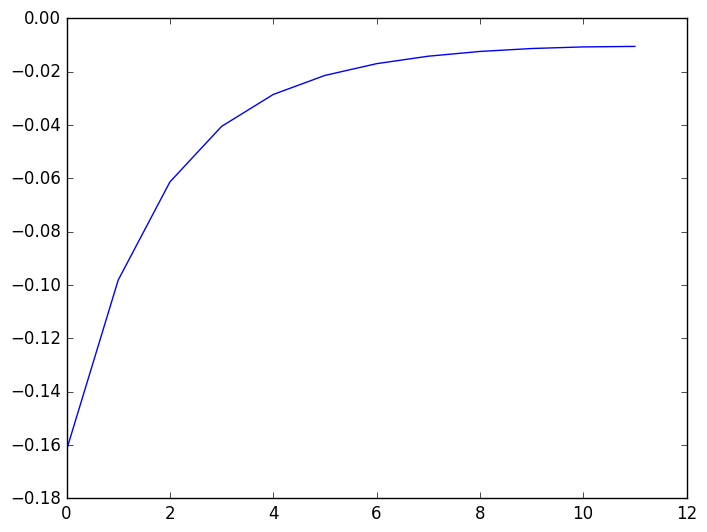

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x31f4c8790>

In [52]:
plot(a03d)

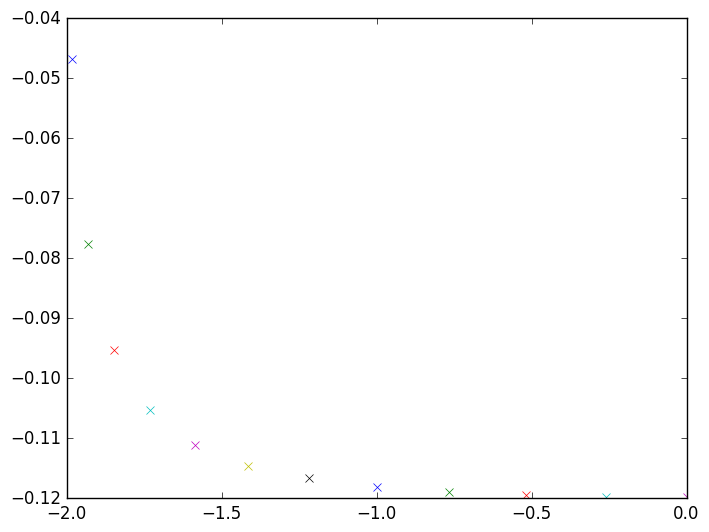

In [53]:
for i = 1:surf.nspan
    plot(surf.yle[i],field2d[i].tev[1].s,"x")
end

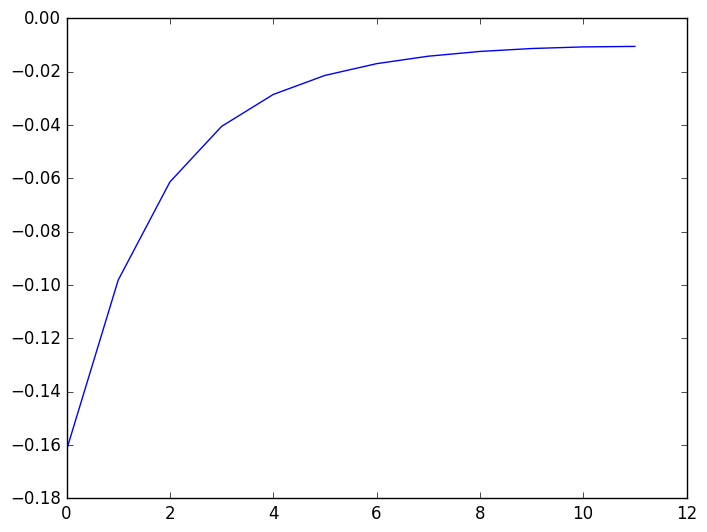

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x318c6ac50>

In [54]:
plot(a03d)

In [55]:

        nshed = Int(0)
        for i = 1:surf.nspan
            #Update 3D effect on A0
            surf2d[i].a0[1] = surf2d[i].a0[1] + a03d[i]

            #2D iteration if LESP_crit is exceeded
            if abs(surf2d[i].a0[1]) > surf2d[i].lespcrit[1]
                #Remove the previous tev
                pop!(field2d[i].tev)
                #Add a TEV with dummy strength
                place_tev(surf2d[i],field2d[i],dt)

                #Add a LEV with dummy strength
                place_lev(surf2d[i],field2d[i],dt)
                surf2d[i].levflag[1] = 1
                nshed += 1
            else
                surf2d[i].levflag[1] = 0
            end
        end
        if nshed > 0
            kelvkutta = KelvinKuttaLLTldvm(surf,surf2d,field2d, nshed)
    
            #Solve for TEV and LEV strengths to satisfy Kelvin condition and Kutta condition at leading edge
    soln = nlsolve(not_in_place(kelvkutta), [-0.01*ones(surf.nspan); 0.01*ones(nshed); zeros(surf.nspan)])
        

        cntr = surf.nspan + 1

        for i = 1:surf.nspan
            field2d[i].tev[length(field2d[i].tev)].s = soln.zero[i]
        end
        for i = 1:surf.nspan
            if surf2d[i].levflag[1] == 1
                field2d[i].lev[length(field2d[i].lev)].s = soln.zero[cntr]
                cntr += 1
            end
        end

        for i = 1:surf.nspan
            #Update incduced velocities on airfoil
            update_indbound(surf2d[i], field2d[i])

            #Calculate downwash
            update_downwash(surf2d[i], [field2d[i].u[1],field2d[i].w[1]])

            #Calculate first two fourier coefficients
            update_a0anda1(surf2d[i])

            bc[i] = surf2d[i].a0[1] + 0.5*surf2d[i].aterm[1]
        end
    
        for i = 1:surf.nspan
            a03d[i] = 0
            for n = 1:surf.nspan
                nn = 2*n - 1
            a03d[i] = a03d[i] - real(nn)*soln.zero[n+surf.nspan+nshed]*sin(nn*surf.psi[i])/sin(surf.psi[i])
        
        end
            surf2d[i].a0[1] = surf2d[i].a0[1] + a03d[i]
        end
end
        for i = 1:surf.nspan
            #Update 3D effect on A0
        

            #Update rest of Fourier terms
            update_a2toan(surf2d[i])

            #Update derivatives of Fourier coefficients
            update_adot(surf2d[i],dt)

            #Set previous values of aterm to be used for derivatives in next time step
            surf2d[i].a0prev[1] = surf2d[i].a0[1]
            for ia = 1:3
                surf2d[i].aprev[ia] = surf2d[i].aterm[ia]
            end

            #Calculate bound vortex strengths
            update_bv(surf2d[i])

            # #Remove vortices that are far away from airfoil
            # if (delvort.flag == 1)
            #     if length(field2d[i].tev) > delvort.limit
            #         if (sqrt((field2d[i].tev[1].x- surf2d[i].bnd_x[div(surf2d[i].ndiv,2)])^2 + (field2d[i].tev[1].z- surf2d[i].bnd_z[div(surf2d[i].ndiv,2)])^2) > delvort.dist*surf2d[i].c)
            #             kelv_enf = kelv_enf + field2d[i].tev[1].s
            #             for i = 1:length(field2d[i].tev)-1
            #                 field2d[i].tev[i] = field2d[i].tev[i+1]
            #             end
            #             pop!(field2d[i].tev)
            #         end
            #     end
            #     if length(field2d[i].lev) > delvort.limit
            #         if (sqrt((field2d[i].lev[1].x- surf2d[i].bnd_x[div(surf2d[i].ndiv,2)])^2 + (field2d[i].lev[1].z- surf2d[i].bnd_z[div(surf2d[i].ndiv,2)])^2) > delvort.dist*surf2d[i].c)
            #             kelv_enf = kelv_enf + field2d[i].lev[1].s
            #             for i = 1:length(field2d[i].lev)-1
            #                 field2d[i].lev[i] = field2d[i].lev[i+1]
            #             end
            #         pop!(field2d[i].lev)
            #         end
            #     end
            # end
            wakeroll(surf2d[i], field2d[i], dt)

            if (surf2d[i].levflag[1] == 1)
                cl[i], cd[i], cm[i] = calc_forces_E(surf2d[i], field2d[i].lev[length(field2d[i].lev)].s, dt)
            else
                cl[i], cd[i], cm[i] = calc_forces(surf2d[i])
            end

        end


cl3d = 2*trapz(cl.*sin(surf.psi), surf.psi)
cd3d = 2*trapz(cd.*sin(surf.psi), surf.psi)
cm3d = 2*trapz(cm.*sin(surf.psi), surf.psi)


        mat = hcat(mat, [t, cl3d, cd3d, cm3d])
  

4×1 Array{Float64,2}:
   0.015 
  50.9412
  13.4982
 -19.9085

In [56]:
nshed

9

In [57]:
for i = 15:surf.nspan
    plot(surf.yle[i],field2d[i].lev[1].s,"x")
end

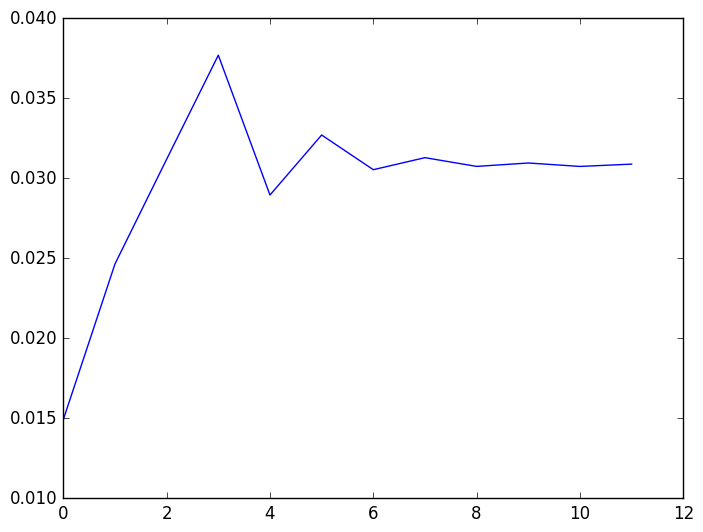

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x31f89c1d0>

In [58]:
plot(bc+a03d)

Betwen LEV strength, TEV strength and a03d there is more than one solution possible to satisfy the criteria. 

Now, a03d only depends on bc = a0 + a1/2

If no LEV formation:
Find bc, find a03d

If LEV formation, 






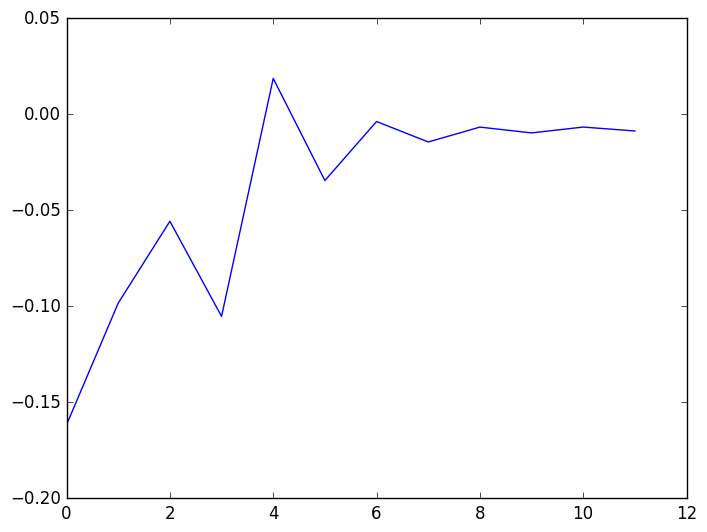

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x31fab9a90>

In [59]:
plot(a03d)
